# A Quantitative Analyst's Workflow for AAPL

---

## Section 1 : Why??

Sebelum kita analisis dan buat model, kita perlu ngerti dulu, kenapa kita mau prediksi harga saham AAPL??

### 1.1. Tujuan - Capital Gain & Risk Management

balik ke dasar dalam finance dan investment, invest ke capital market itu tujuannya yang gedein uang kita. nah model disini dipake untuk bantu analisis informasi atau data yang ada dengan lebih efisien dan otomatis. of course model gaakan sempurna, karena pada dasarnya sulit untuk mebemukan pola dalam human behavior penggerak ekonomi. tapi setidaknya ini bisa dijadikan bantuan dalam management investment portofolio kita.

### 1.2. Apa yang Mau di Prediksi??

Kita mau bikin model yang bisa prediksi close value dari AAPL keesokan harinya.  secara simpel itu kaya gini

$Prediksi Harga Besok = fungsi(Data Haei Ini)$

atau :

$Predicted\_Close(t+1) = f(X_t)$



Btw, kita cuma pake data sampe hari ini buat nebak harga besok. Gak boleh tau data besok buat bisa prediksi hari ini, ini disebut lookahead bias, dan ini haram hukumnya di finance modelling.

so, fitur yang kita pake untuk prediksi adalah

- harga pembukaan, tertinggi, terendah, close, dan volume (OHCLC).
- semua data diambil dari data hari hari sebelumnya, sampai hari ini.

### 1.3. Datanya dari mana?? `yfinance` jawabannya

Kita akan menggunakan data harian `OHLCV` (Open, High, Low, Close, Volume) untuk saham 'AAPL', menggunakan `yfinance`. kita bakal ambil data selama 5 tahun terakhir, kenapa 5 tahun?. well, 5 tahun adalah waktu yang udah cukup untuk dapet pola perubahan pasar, naik turun, big event kaya covid dan kenaikan suku bunga. dan juga ga terlalu lama yang bikin data ga relevan ikut masuk dan bikin model bias atau pusing nangkep pola.

#### Dependencies 


In [11]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from xgboost import XGBRegressor
import shap
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

# Set style background ungu gelap
plt.style.use('dark_background')
plt.rcParams['figure.figsize'] = (15, 7)

print("Semua library berhasil di-import.")

Semua library berhasil di-import.


#### Data

In [41]:
# ticker dan periode waktu
ticker = 'AAPL'
start_date = '2019-01-01'
end_date = pd.to_datetime('today').strftime('%Y-%m-%d')

try:
    data = yf.download(ticker, start=start_date, end=end_date)
    if data.empty:
        raise ValueError("Datanya kosong. Mungkin ticker-nya salah atau gak ada data.")
    print(f"Data {ticker} berhasil diambil dari {start_date} sampai {end_date}.")
    print("\nInformasi umum data:")
    data.info()
except Exception as e:
    print(f"Error ambil data: {e}")

# Drop 'AAPL'
data.columns = data.columns.droplevel(1)  

# Lihat isi data
print("\nLima baris pertama:")
display(data.head())

print("\nStatistik umum:")
display(data.describe())

/var/folders/fz/vv4pwkl920qbrm78wf1yyykr0000gn/T/ipykernel_15919/3107071363.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed

Data AAPL berhasil diambil dari 2019-01-01 sampai 2025-08-02.

Informasi umum data:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1655 entries, 2019-01-02 to 2025-08-01
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   (Close, AAPL)   1655 non-null   float64
 1   (High, AAPL)    1655 non-null   float64
 2   (Low, AAPL)     1655 non-null   float64
 3   (Open, AAPL)    1655 non-null   float64
 4   (Volume, AAPL)  1655 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 77.6 KB

Lima baris pertama:


Price,Close,High,Low,Open,Volume
Date,,,,,
2019-01-02,37.617859,37.839395,36.738870,36.896088,148158800
2019-01-03,33.870834,34.711709,33.825574,34.297226,365248800
2019-01-04,35.316761,35.385843,34.254354,34.428245,234428400
2019-01-07,35.238152,35.452541,34.754589,35.421573,219111200
2019-01-08,35.909897,36.164781,35.378693,35.626428,164101200



Statistik umum:


Price,Close,High,Low,Open,Volume
count,1655.000000,1655.000000,1655.000000,1655.000000,1.655000e+03
mean,142.019374,143.475069,140.412431,141.877869,9.091159e+07
std,56.675526,57.164388,56.133004,56.636381,5.154756e+07
min,33.870834,34.711709,33.825574,34.297226,2.323470e+07
25%,108.975529,110.504430,106.925575,109.233589,5.537185e+07
50%,146.824814,148.447085,145.348127,146.509495,7.785210e+07
75%,181.513252,183.466986,180.074655,181.402657,1.089922e+08
max,258.396667,259.474086,257.010028,257.568678,4.265100e+08


**Analisis :**

Junmlah data  (count) 1653 sekitar 6.5 tahun. 

Mean Close 141. open high low, juga ada dikisaran yang sama, stabil.

volume rata rata sekita 9.0 juta saham per hari, sangat likuid

Distribusi - std close - 56.7 volitilitas harian cukup tinggi, std volume - 5.1 jt, fluktuasi besar juga. ada hari tertentu yang nilainya ekstrim. Intinya range of distribution yang tinggi mewajibkan scaling atau norm sebelum modelling.

harga close terendah  33, harga close tertinggi 258. selisih besar. volume min 23jt, volume max 400 jt. selisih besar juga. masuk akal, tapi sebelum modelling kita perlu log transform ini, biar rentang nya lebih stabil. 

Quartile - median cloose 146, lebih tinggi dari meannya, menandakan varians rendah, atau left skewed, atau distribusi tidak normal.

IQR (InterQuartile Range) ; Q3 - Q1 = 180 - 110 -> 70. perubahan yang cukup besar dan signifikan.

Kesimpulan : Data cukup banyak dan berkualitas serta valid, saham likuid, violitas tinggi, bagus untuk model prediksi, namun perlu dihandle outlier dengan normalisasi.





	Daily Range: High - Low → indikator volatilitas harian
	•	Price Change: Close - Open → arah pergerakan harian
	•	Body Ratio: (Close - Open) / (High - Low) → bentuk candlestick
	•	Normalized Volume: (Volume - mean) / std → volume outlier detection
	•	Lag Features: Harga & volume kemarin, 3 hari lalu, 7 hari lalu, dst.

---

## Section 2 : EDA

EDA atau exploratori data analysis adalah menganalisa data, artinya kita peke metode statistik dan analisis lainnya untuk memahami data, seperti bagaimana data terdistribusi, tren paarnya itu gimana, analisis statistik untuk dapetin informasi statistik Inferensi (tiem series, sequential).

### 2.1. Handling Null Values

In [42]:
data.isnull().sum()

Price
Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64

lucky me gaada missing value, lets just move on

### 2.2. Grafik Harga Historis dan Valume

kita bakal bikin grafik harga penutupan (Close) dan volume perdagangan pada hari itu, dan kemudian melihat pola yang ada. 

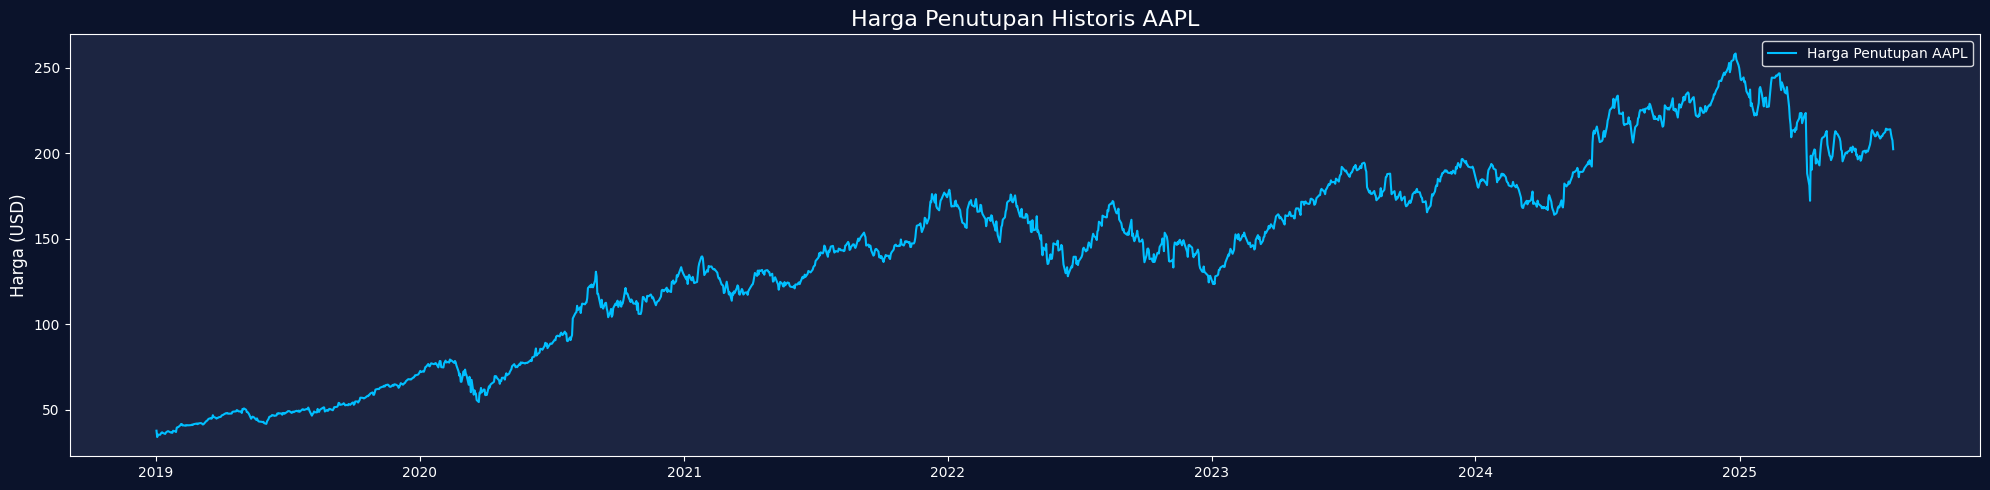

In [51]:
fig, ax1 = plt.subplots(figsize=(20, 5)); fig.patch.set_facecolor('#0b132b'); ax1.set_facecolor('#1c2541')

ax1.plot(data['Close'], label='Harga Penutupan AAPL', color='#00bfff')
ax1.set_title(f'Harga Penutupan Historis {ticker}', fontsize=16, color='white')
ax1.set_ylabel('Harga (USD)', fontsize=12, color='white')
ax1.legend(facecolor='#0b132b', edgecolor='white')

ax1.tick_params(colors='white')
for spine in ax1.spines.values(): spine.set_color('white')
plt.tight_layout(); plt.show()

**Analisis :**

membangun model prediksi harga saham, maka analisis kita harus fokus ke keterkaitan antara harga penutupan dan volume perdagangan, serta bagaimana pola historis keduanya bisa memberikan sinyal prediktif. Jadi kita gak cuma ngelihat tren, tapi mulai berpikir: apakah volume bisa bantu memprediksi pergerakan harga berikutnya?

Dari grafik harga penutupan, terlihat bahwa AAPL mengalami tren naik yang cukup stabil. Artinya, ada pola historis yang bisa ditangkap oleh model time-series atau machine learning. Harga penutupan menunjukkan autocorrelation—pergerakan hari ini sebagian besar dipengaruhi oleh hari-hari sebelumnya. Ini bagus, karena model seperti ARIMA, LSTM, atau bahkan XGBoost dengan fitur waktu bisa memanfaatkan pola ini.

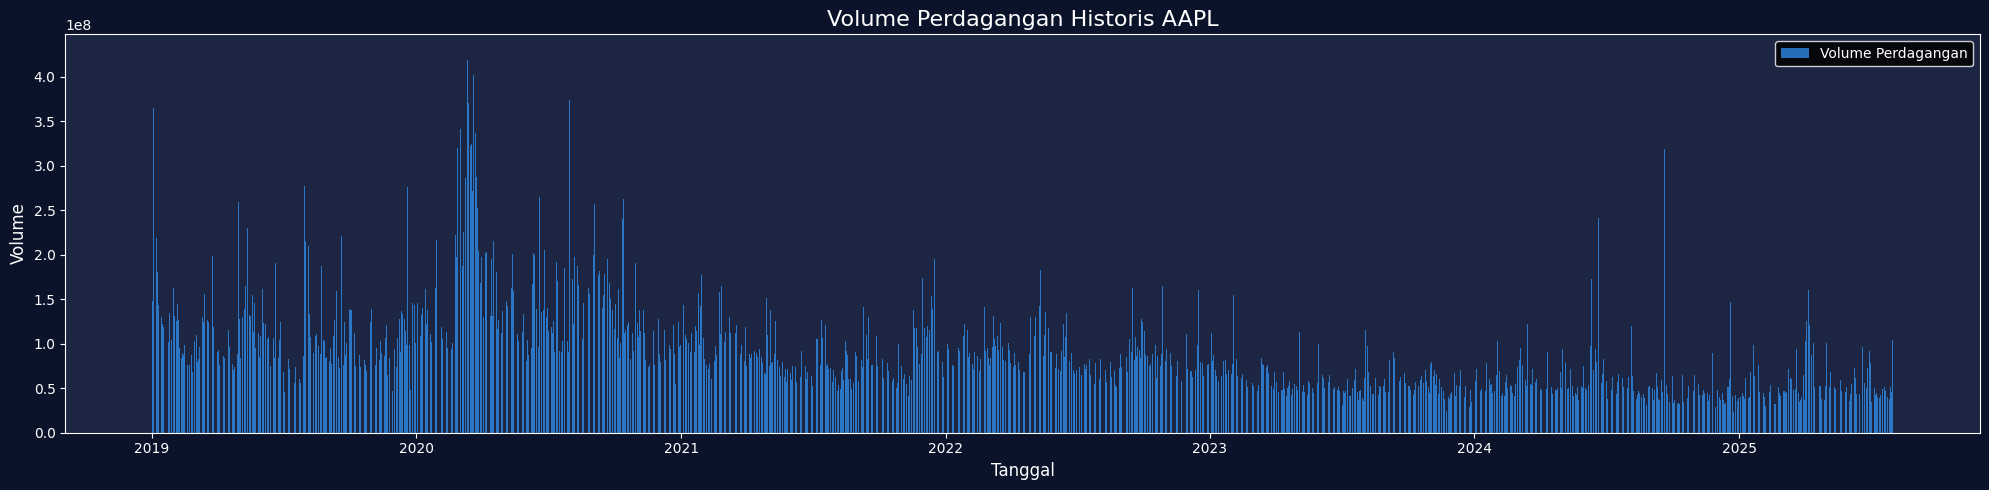

In [50]:
fig, ax2 = plt.subplots(figsize=(20, 5)); fig.patch.set_facecolor('#0b132b'); ax2.set_facecolor('#1c2541')

ax2.bar(data.index, data['Volume'], label='Volume Perdagangan', color='#3399ff', alpha=0.7)
ax2.set_title(f'Volume Perdagangan Historis {ticker}', fontsize=16, color='white')
ax2.set_ylabel('Volume', fontsize=12, color='white')
ax2.set_xlabel('Tanggal', fontsize=12, color='white')
ax2.legend(facecolor='black', edgecolor='white')

ax2.tick_params(colors='white')
for spine in ax2.spines.values(): spine.set_color('white')
plt.tight_layout(); plt.show()

**Analisis :**

Sekarang, lihat grafik volume. Volume tidak memiliki tren yang stabil, tapi justru sangat fluktuatif dan kadang melonjak drastis. Namun, lonjakan volume ini sering kali mendahului pergerakan harga besar. Ini berarti volume bisa dijadikan sebagai leading indicator. Misalnya, lonjakan volume tanpa kenaikan harga bisa menandakan akumulasi sebelum breakout. Ini sinyal yang sangat berguna buat model prediksi.

Insight untuk modelling:
- Harga penutupan memiliki pola tren dan seasonality → cocok untuk time-series modelling.
- Volume memiliki karakteristik volatil dan bisa menjadi sinyal awal sebelum pergerakan harga → berguna sebagai fitur prediktor.
- Kombinasi keduanya penting. Harga penutupan sebagai target variabel, volume sebagai salah satu fitur prediktif (bisa ditambah turunan lain seperti perubahan volume, rata-rata bergerak, RSI, dll).
- Untuk hasil lebih baik, model bisa juga diberi fitur turunan waktu seperti hari, minggu, dan kuartal karena saham punya pola musiman.

Intinya, secara data: harga penutupan memberi fondasi tren, sementara volume memberi sinyal momentum. Gabungan ini yang akan memperkuat model prediksi harga ke depan.

### 2.3. Decomposisi Time Series

“Kita ibaratnya ngeluarin ‘suara murni’ dari sinyal bising harga saham. Dekomposisi bantu kita lihat apakah saham itu lagi naik secara konsisten, punya pola musiman, atau sedang ngalamin kondisi pasar yang gak stabil.”

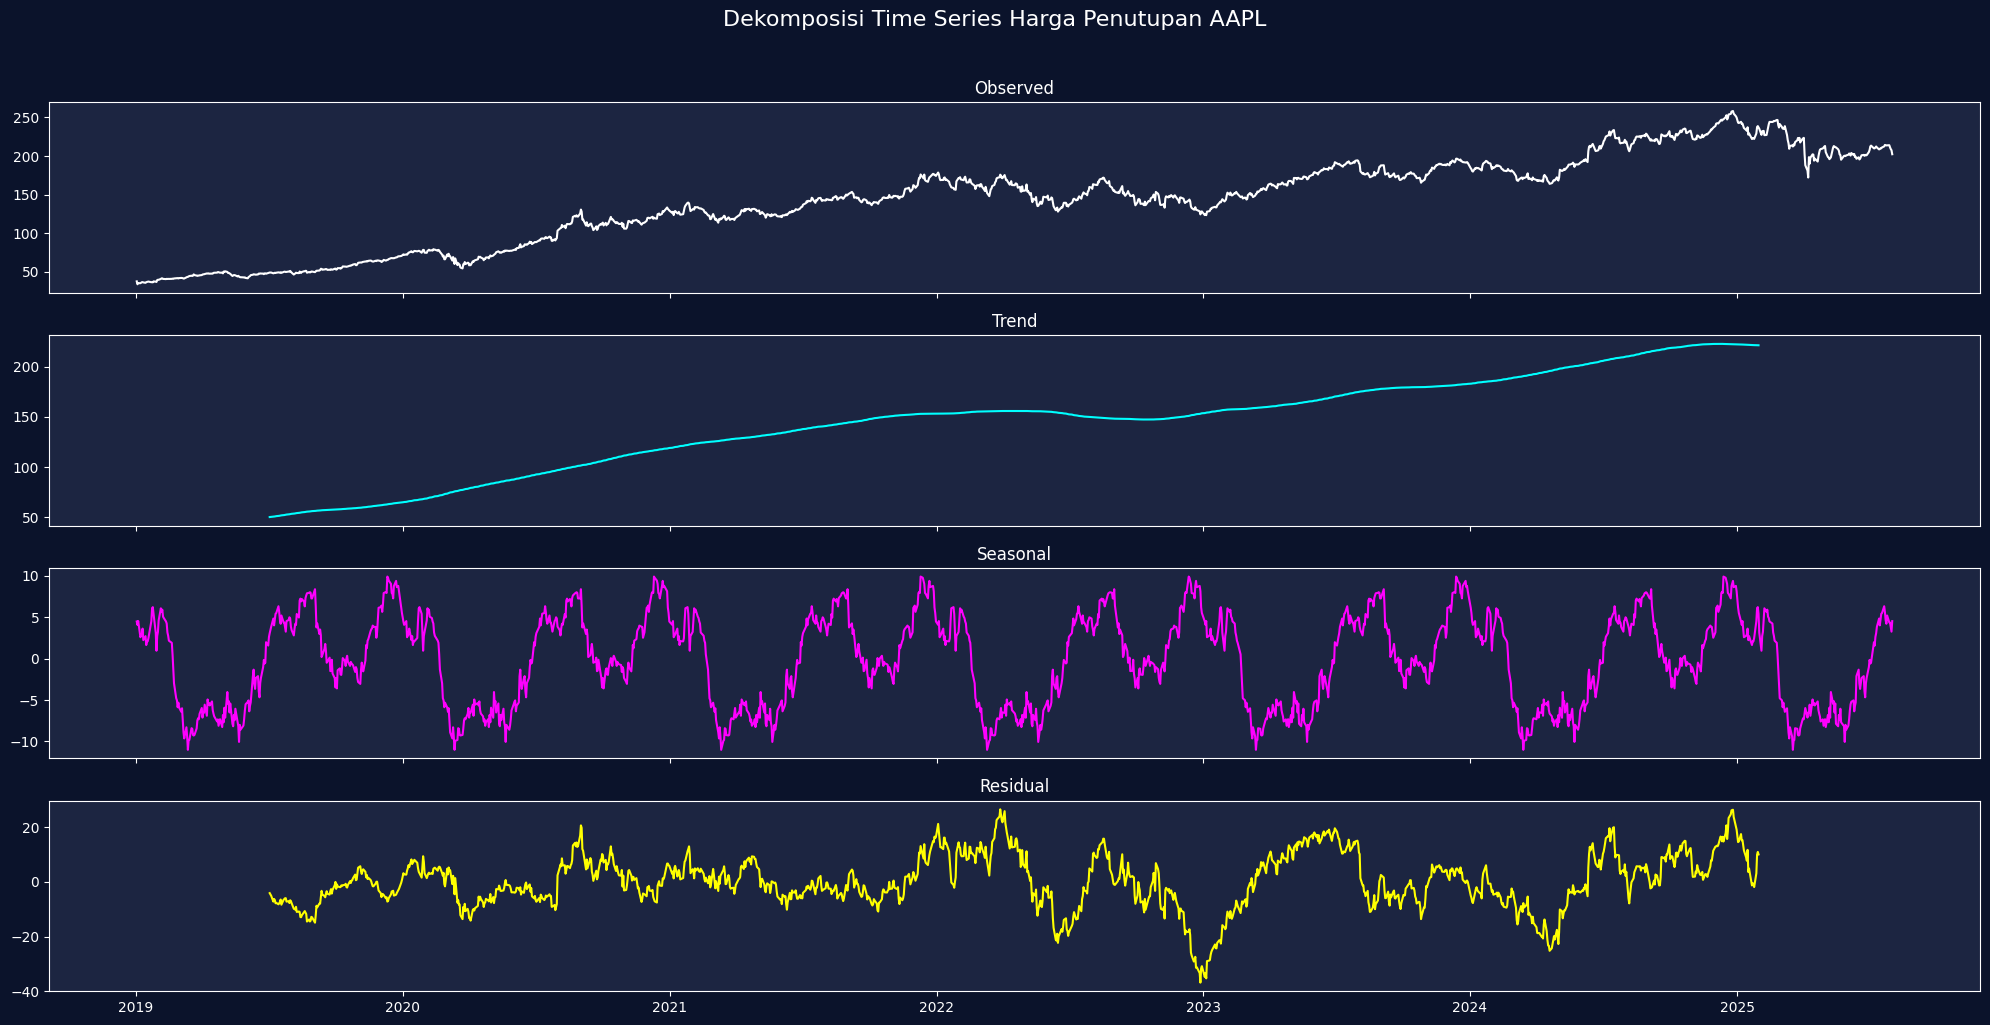

In [59]:
# Simpan hasil dekomposisi
decomposition = seasonal_decompose(data['Close'], model='additive', period=252)

# Buat plot kosong
fig, axes = plt.subplots(4, 1, figsize=(20, 10), sharex=True)

# Set background gelap
fig.patch.set_facecolor('#0b132b')
for ax in axes:
    ax.set_facecolor('#1c2541')
    ax.tick_params(colors='white')
    ax.title.set_color('white')
    ax.yaxis.label.set_color('white')
    for spine in ax.spines.values():
        spine.set_color('white')

# Plot tiap komponen dengan warna custom
axes[0].plot(decomposition.observed, color='white')
axes[0].set_title('Observed')

axes[1].plot(decomposition.trend, color='cyan')
axes[1].set_title('Trend')

axes[2].plot(decomposition.seasonal, color='magenta')
axes[2].set_title('Seasonal')

axes[3].plot(decomposition.resid, color='yellow')
axes[3].set_title('Residual')

# Judul utama
plt.suptitle('Dekomposisi Time Series Harga Penutupan AAPL', y=1.02, fontsize=16, color='white')
plt.tight_layout()
plt.show()

**Analisis**

Grafik atas: Data asli (Close). Itu harga saham AAPL harian dari 2019 sampai 2025. Naik-turun, kelihatan agak random.

Grafik kedua: Trend. Ini kayak kita “mulusin” grafik asli, buat lihat arah jangka panjang. “Kalau dihilangin naik-turun harian, sebenarnya harga AAPL cenderung naik dari waktu ke waktu.”

Grafik ketiga: Seasonality (pola musiman). Ini nunjukin pola yang berulang tiap tahun. “Ada kecenderungan harga AAPL ngalamin siklus naik-turun setiap tahun. Tapi bisa jadi ini cuma pola statistik, bukan peluang cuan pasti.”

Grafik keempat: Residual (sisa). Ini sisa-sisa yang nggak bisa dijelaskan sama trend atau seasonality.

### 2.4. Stasioneritas: Uji Augmented Dickey-Fuller (ADF)

Intinya uji ADF adalah untuk ngecek apakah data kita stasioner atau tidak. stasioner sendiri adalah sifat statistik data yang tidak berubah seiring waktu. kestabilan data. saham itu biasanya non stasioner karena biasa ada tren.

Inti ADF Test
- Hipotesis nol (H0): Data ini non-stasioner
- Hipotesis alternatif (H1): Data ini stasioner

Interpretasi:
- Kalau p-value > 0.05 → Kita gagal menolak H0 → Data non-stasioner
- Kalau p-value ≤ 0.05 → Kita tolak H0 → Data stasioner


In [ ]:
# Simpan harga asli dulu
close_data = data['Close'].copy()

# Lalu buat data imbal hasil dari harga
return_data = close_data.pct_change()

def perform_adf_test(series, series_name):
    """Melakukan dan mencetak hasil Uji ADF."""
    result = adfuller(series.dropna())
    adf_stat = result[0]
    p_value = result[1]
    critical_values = result[4]

    print(f'Uji Augmented Dickey-Fuller untuk: {series_name}')
    print(f'ADF Statistic: {adf_stat:.4f}')
    print(f'p-value: {p_value:.4f}')
    print('Critical Values:')
    for key, value in critical_values.items():
        print(f'\t{key}: {value:.4f}')
    
    if p_value <= 0.05:
        print(f'Kesimpulan: Data stasioner (p-value <= 0.05). Kita menolak hipotesis nol.')
    else:
        print(f'Kesimpulan: Data non-stasioner (p-value > 0.05). Kita gagal menolak hipotesis nol.')

# Uji pada harga penutupan asli
perform_adf_test(data['Close'], 'Harga Penutupan (Original)')

# Uji pada first difference (imbal hasil harian)
# Differencing adalah cara umum untuk membuat data menjadi stasioner
data = data['Close'].pct_change()
perform_adf_test(data, 'Imbal Hasil Harian (First Difference)')

Uji Augmented Dickey-Fuller untuk: Harga Penutupan (Original)
ADF Statistic: -1.5596
p-value: 0.5039
Critical Values:
	1%: -3.4343
	5%: -2.8633
	10%: -2.5677
Kesimpulan: Data non-stasioner (p-value > 0.05). Kita gagal menolak hipotesis nol.
Uji Augmented Dickey-Fuller untuk: Imbal Hasil Harian (First Difference)
ADF Statistic: -13.2810
p-value: 0.0000
Critical Values:
	1%: -3.4343
	5%: -2.8633
	10%: -2.5677
Kesimpulan: Data stasioner (p-value <= 0.05). Kita menolak hipotesis nol.


**Analisis :**

Harga saham naik turun dengan tren → nggak stabil → model gak bisa dipakai langsung

Kita ubah data: dari harga → ke selisih harga (imbal hasil)

Hasilnya? Data jadi lebih tenang dan stabil → model cocok dan bisa belajar pola

Model seperti ARIMA butuh data yang stasioner, supaya bisa bikin prediksi akurat.

Kalau langsung pakai data non-stasioner, prediksi bisa ngawur.

### 2.4 Memori Pasar: Analisis Autokorelasi (ACF) dan Autokorelasi Parsial (PACF)

Waktu kamu bikin model ARIMA, kamu harus tahu:
- AR (Autoregressive) → berapa banyak lag yang harus dipakai? (parameter p)
- MA (Moving Average) → berapa banyak error sebelumnya yang ikut diperhitungkan? (parameter q)

Kita perlu tahu pasi :

Apakah masa lalu itu punya memori? Dan kalau iya, seberapa panjang memori itu?

Itulah peran ACF dan PACF.


**ACF (Autocorrelation Function)**

*“Apakah harga hari ini berkaitan dengan harga kemarin? Atau 2 hari lalu? Atau 5 hari lalu?”*

ACF ngukur semua korelasi antar waktu, tanpa mikirin apakah korelasi itu langsung atau cuma efek rantai.

Contoh: Kalau harga hari ini mirip kemarin, dan kemarin mirip 2 hari lalu, ACF akan kasih nilai tinggi ke lag 2 → meskipun sebenarnya cuma efek dari kemarin.

**PACF (Partial ACF)**

“Setelah aku perhitungkan harga kemarin, apakah harga 2 hari lalu MASIH punya pengaruh ke hari ini?”

Jadi PACF itu fokus ke pengaruh langsung dari tiap lag, setelah buang efek perantara.

**Why**

Setelah data stasioner (pakai differencing tadi), kita butuh tahu:
- Model AR kamu butuh lag berapa? (dilihat dari PACF)
- Model MA kamu butuh error lag berapa? (dilihat dari ACF)

Dengan kata lain: PACF bantu nentuin p, ACF bantu nentuin q.

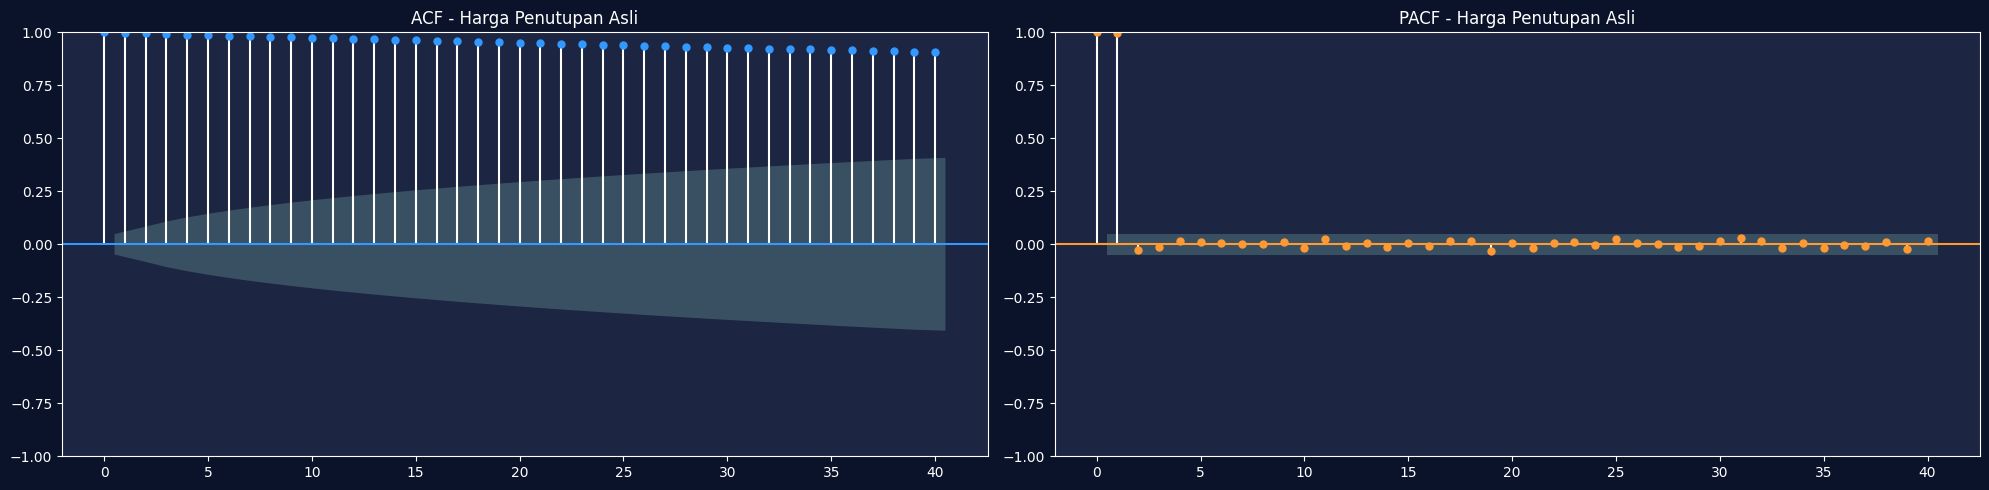

In [64]:
# Plot ACF dan PACF pada harga penutupan asli (tema gelap)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
fig.patch.set_facecolor('#0b132b')
ax1.set_facecolor('#1c2541')
ax2.set_facecolor('#1c2541')

plot_acf(close_data.dropna(), ax=ax1, lags=40, color='#3399ff')
ax1.set_title('ACF - Harga Penutupan Asli', color='white')
ax1.tick_params(colors='white')
for spine in ax1.spines.values(): spine.set_color('white')

plot_pacf(close_data.dropna(), ax=ax2, lags=40, color='#ff9933')
ax2.set_title('PACF - Harga Penutupan Asli', color='white')
ax2.tick_params(colors='white')
for spine in ax2.spines.values(): spine.set_color('white')

plt.tight_layout()
plt.show()

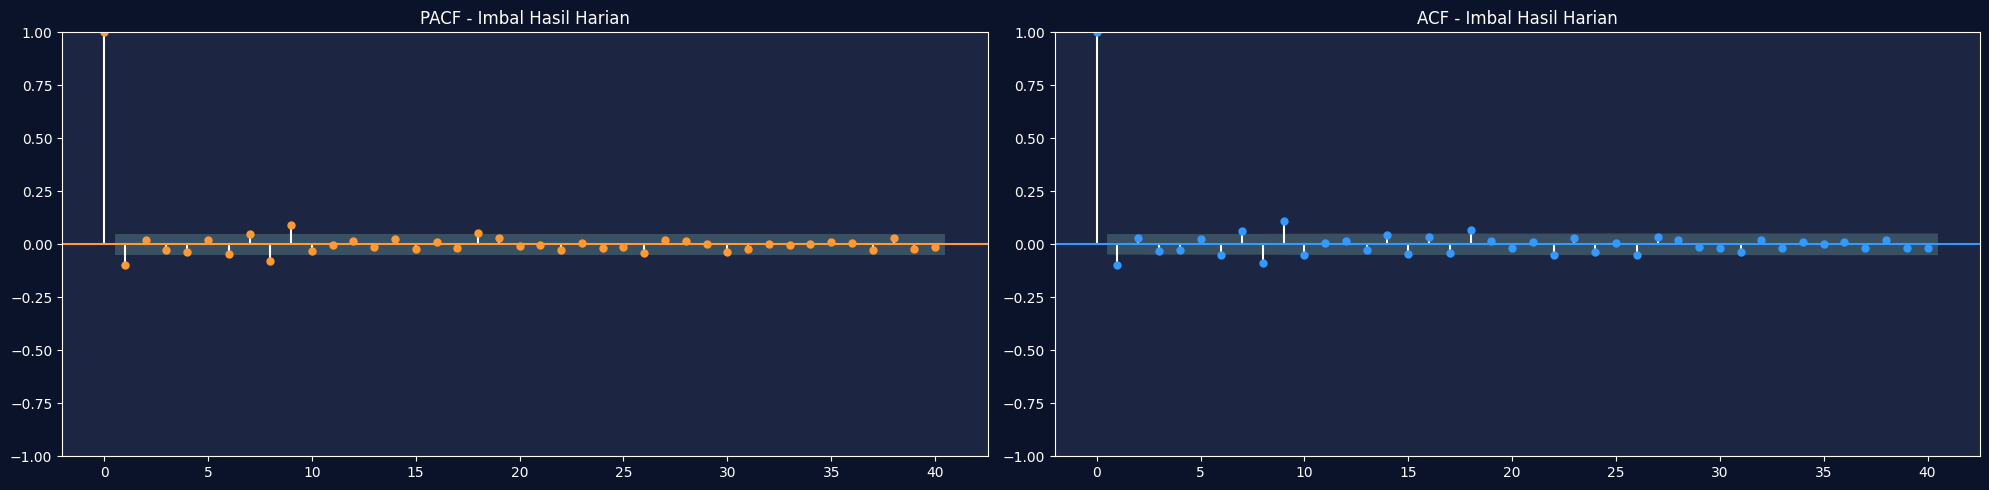

In [63]:
# Plot ACF dan PACF pada data yang sudah di-differencing (tema gelap)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
fig.patch.set_facecolor('#0b132b')
ax1.set_facecolor('#1c2541')
ax2.set_facecolor('#1c2541')

plot_pacf(return_data.dropna(), ax=ax1, lags=40, color='#ff9933')
ax1.set_title('PACF - Imbal Hasil Harian', color='white')
ax1.tick_params(colors='white')
for spine in ax1.spines.values(): spine.set_color('white')

plot_acf(return_data.dropna(), ax=ax2, lags=40, color='#3399ff')
ax2.set_title('ACF - Imbal Hasil Harian', color='white')
ax2.tick_params(colors='white')
for spine in ax2.spines.values(): spine.set_color('white')

plt.tight_layout()
plt.show()

**AFC** itu ngukur korelasi antar waktu (lag).

*“Seberapa kuat hubungan harga hari ini dengan harga-harga sebelumnya?”*

Misal:
- Hari ini sama kemarin (lag-1)
- Hari ini sama 2 hari lalu (lag-2)
- Dan seterusnya…

Di grafik ACF tadi, batang batangnya nggak cepet turun →
yang artinya masih ada hubungan jangka panjang. Yang mana itu tanda data belum stasioner.

**PACF** ACF tadi ngasih tau hubungan total, PACF cuma ngasih tau hubungan langsung aja, tanpa campur tangan lag-lag lain.

*"Seberapa pengaruh si lag-1 ke harga sekarang, tanpa pengaruh lag-2, lag-3, dst."*

Nah di grafik PACF, lag-1 tinggi banget, terus langsung drop.
Itu artinya... harga hari ini paling dipengaruhi harga kemarin doang. Sisanya? Nggak ngaruh banyak.

Kesimpulan:
Data belum stasioner (ACF lambat turun). Tapi ada indikasi - cukup pakai lag-1 udah oke (dari PACF).
Jadi :
- Lakuin differencing sekali biar stasioner (d=1).
- Pakai ARIMA (p=1, d=1, q=?) → tinggal cek q pake ACF-nya setelah differencing.

### 2.5. Hipotesis

**Hipotesis 1**: AAPL sangat non-stasioner dan punya tren naik jangka panjang

- Harga AAPL itu naik-naik terus, ga stabil di satu rata-rata. Jadi datanya “bergerak” terus, bukan cuma fluktuasi kecil di sekitar satu nilai tetap.

Justifikasi: 
- Di grafik, kita lihat ada pola naik terus tiap tahun.
- Dekomposisi nunjukin komponen trend yang kuat.
- Uji ADF (Augmented Dickey-Fuller) kasih p-value tinggi ⇒ kita gagal tolak hipotesis nol ⇒ data non-stasioner.

Kesimpulan : Model kayak ARIMA perlu differencing dulu biar datanya stasioner.

**Hipotesis 2**: Harga besok paling dipengaruhi harga hari ini

- Kalau kamu mau nebak harga besok, liat aja harga hari ini. Harga dua atau tiga hari lalu udah mulai kehilangan “pengaruh”.

Justifikasi:
- PACF (Partial Autocorrelation Function) nunjukin korelasi kuat cuma di lag-1.
- Artinya harga hari ini punya informasi paling penting buat nebak harga besok.
- Korelasi di lag-2 ke atas drop tajam ⇒ efek masa lalu cepat hilang.

Kesimpulan - Model AR(1) mungkin cukup, tapi AR(2) ke atas bakal overfitting kecuali data baru berubah.

**Hipotesis 3**: Ada pengelompokan volatilitas

- Kadang harga AAPL “tenang-tenang aja”, tapi kadang tiba-tiba gonjang-ganjing. Ini disebut volatility clustering.

Justifikasi:
- Plot residu dari dekomposisi nunjukin varian yang naik turun drastis.
- Kalau varian berubah-ubah gini ⇒ asumsi homoskedastisitas di model linear dilanggar.
- Ini cocok banget buat pendekatan ARCH/GARCH, yaitu model yang fokus ke perubahan varian.

Kesimpulan - Model seperti GARCH bisa lebih cocok buat menangani pola volatilitas ini dibanding model linear biasa kayak ARIMA.

## Section 3 : Preprocessing and Feature Engeneering

### 3.1. Missing Values

sebelum analisis, kita harus pastikan tidak ada nilai yang hilang dalam data. kalo ada kita bias pake metode forward fill (`ffill`). Kenapa? ... Karena metode ini akan isi nilai kosong dengan nilai terakhir yang ada sebelum kosong itu.

Contoh :
```python
Hari 1: 150  
Hari 2: NaN -> 150  
Hari 3: 153
```

Kenapa harus gitu?.. karena di prinsi time series modelling, kita gaboleh bocorin masa denpan. itu kan kita cuman pake informasi yang ada sebelumnya.

In [65]:
# Memeriksa nilai yang hilang
print("Jumlah nilai yang hilang per kolom:")
print(data.isnull().sum())

# Menangani missing values jika ada (misalnya, dari hari libur pasar)
data.ffill(inplace=True)
print("\nJumlah nilai yang hilang setelah forward fill:")
print(data.isnull().sum())

Jumlah nilai yang hilang per kolom:
Price
Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64

Jumlah nilai yang hilang setelah forward fill:
Price
Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64
